# Measuring Campaign ROI
### Table of Contents
1. Problem Analysis
2. Data Preprocessing
3. Exploratory Data Analysis (EDA)
4. Acquisition Cost Sub-Model
5. Conversion Rate Sub-Model


### 1. Problem Analysis

In the highly competitive banking industry, it is important for banks to maintain their competitiveness by focusing their marketing efforts on campaigns that generate the highest return on investment (ROI). However, banks often struggle to quantify the ROI for different marketing efforts, making it difficult to determine which campaigns generate the highest profitability and long-term customer value. Therefore, being able to measure and predict the cost-effectiveness of marketing campaigns is crucial for efficient allocation of marketing budgets, ensuring that a bank employs the most effective marketing strategy.

To tackle this challenge, we aim to develop a model that can predict the ROI of various bank marketing campaigns based on key influencing factors such as customer lifetime value (CLV), conversion rate and acquisition cost. Conversion rate and acquisition cost will be estimated using 2 individual models, using campaign-specific features such as campaign type (email marketing, telemarketing, etc), campaign duration, target audience, campaign langauge, and campaign timeframe as inputs. Then, the outputs of these 2 sub-models will be used to develop a model to predict ROI.

Through this, not only are we able to predict and quantify the cost-effectiveness of a given marketing campaign, but also generate recommendations on which bank marketing campaigns a bank should focus on.

### 2. Data Preprocessing

In [477]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# load datasets
campaigns_df = pd.read_csv("../../data/processed/campaigns.csv")
customer_df =  pd.read_csv("../../data/processed/customer.csv")
engagement_details_df = pd.read_csv("../../data/processed/engagement_details.csv")
engagement_details_df.head(), customer_df.head(), campaigns_df.head()
campaigns_df

,campaign_id,campaign_type,target_audience,campaign_duration,conversion_rate,acquisition_cost,roi,campaign_language,impressions,clicks
0,50,Display Advertising,35-44,45,0.0447,12246.83,4.78,German,48072,2149.0
1,70,Affiliate Marketing,25-34,45,0.1374,16658.91,4.18,French,12180,1674.0
2,89,Telemarketing,45-54,45,0.0647,17649.59,4.30,German,48028,NaN
3,27,Display Advertising,35-44,45,0.0992,6897.91,3.75,French,14504,1439.0
4,72,Display Advertising,35-44,30,0.0880,7144.46,3.11,English,27811,2447.0
...,...,...,...,...,...,...,...,...,...,...
94,3,Email Marketing,35-44,30,0.0656,4098.96,3.01,French,33782,2216.0
95,77,Display Advertising,45-54,60,0.0316,8296.65,2.69,German,29179,922.0
96,75,Display Advertising,45-54,60,0.0379,6223.27,4.28,Mandarin,18497,701.0
97,20,Search Engine Optimization,25-34,30,0.1804,14319.03,4.61,English,9445,1704.0


In [478]:
### Obtaining derived variables ###

# Join engagement_details with customer.csv on customer_id, adding CLV column
engagement_details_with_clv = engagement_details_df.merge(
    customer_df[['customer_id', 'customer_lifetime_value']],
    on='customer_id',
    how='left'
)

# Compute the average CLV per campaign
avg_clv_per_campaign = engagement_details_with_clv.groupby('campaign_id', as_index=False)['customer_lifetime_value'].mean()
avg_clv_per_campaign.rename(columns={'customer_lifetime_value': 'avg_clv'}, inplace=True)

# Merge campaigns.csv with avg_clv_per_campaign on campaign_id
merged_campaigns = campaigns_df.merge(avg_clv_per_campaign, on='campaign_id', how='left')

# Select and rearrange the required columns
df = merged_campaigns[['campaign_id', 'campaign_type', 'target_audience', 'campaign_duration',
                       'campaign_language', 'conversion_rate', 'acquisition_cost', 'avg_clv', 'roi']]
df

,campaign_id,campaign_type,target_audience,campaign_duration,campaign_language,conversion_rate,acquisition_cost,avg_clv,roi
0,50,Display Advertising,35-44,45,German,0.0447,12246.83,749.995563,4.78
1,70,Affiliate Marketing,25-34,45,French,0.1374,16658.91,683.984101,4.18
2,89,Telemarketing,45-54,45,German,0.0647,17649.59,760.900899,4.30
3,27,Display Advertising,35-44,45,French,0.0992,6897.91,753.463856,3.75
4,72,Display Advertising,35-44,30,English,0.0880,7144.46,750.644040,3.11
...,...,...,...,...,...,...,...,...,...
94,3,Email Marketing,35-44,30,French,0.0656,4098.96,719.609809,3.01
95,77,Display Advertising,45-54,60,German,0.0316,8296.65,748.420556,2.69
96,75,Display Advertising,45-54,60,Mandarin,0.0379,6223.27,736.007660,4.28
97,20,Search Engine Optimization,25-34,30,English,0.1804,14319.03,720.994040,4.61


### 3. Exploratory Data Analysis (EDA)

##### Summary Statistics

In [479]:
# Summary statistics and pairplot to explore relationships
summary_stats = df.describe(include='all')
summary_stats

,campaign_id,campaign_type,target_audience,campaign_duration,campaign_language,conversion_rate,acquisition_cost,avg_clv,roi
count,99.000000,99,99,99.000000,99,99.000000,99.000000,99.000000,99.000000
unique,NaN,5,5,NaN,5,NaN,NaN,NaN,NaN
top,NaN,Display Advertising,35-44,NaN,Mandarin,NaN,NaN,NaN,NaN
freq,NaN,38,30,NaN,22,NaN,NaN,NaN,NaN
mean,50.000000,NaN,NaN,39.545455,NaN,0.089924,18448.712323,734.303477,3.337374
std,28.722813,NaN,NaN,20.825942,NaN,0.046705,24413.643916,23.750505,1.030370
min,1.000000,NaN,NaN,15.000000,NaN,0.018600,328.710000,681.818278,1.510000
25%,25.500000,NaN,NaN,15.000000,NaN,0.050900,3338.125000,718.105437,2.500000
50%,50.000000,NaN,NaN,30.000000,NaN,0.081600,10013.410000,733.044583,3.390000
75%,74.500000,NaN,NaN,60.000000,NaN,0.121900,20192.715000,750.753159,4.300000


The variable acquisition_cost has high variability, we will reduce its spread by performing log-transformation.
Furthermore, it also has a significantly larger scale compared to conversion_rate and avg_clv, we should consider feature scaling to ensure consistency across input variables. 

In [ ]:
# Log-transform the acquisition_cost column
df['log_acquisition_cost'] = np.log(df.acquisition_cost)
# Encode an order for target_audience
df['target_audience'] = pd.Categorical(df.target_audience, ordered=True)

##### Campaign-related features vs Acquisition Cost, Conversion Rate, CLV
First, let's explore the relationships between the campaign-related features and CLV, acquisition cost, conversion rate and respectively. These insights may drive our decisions regarding feature and model selection.

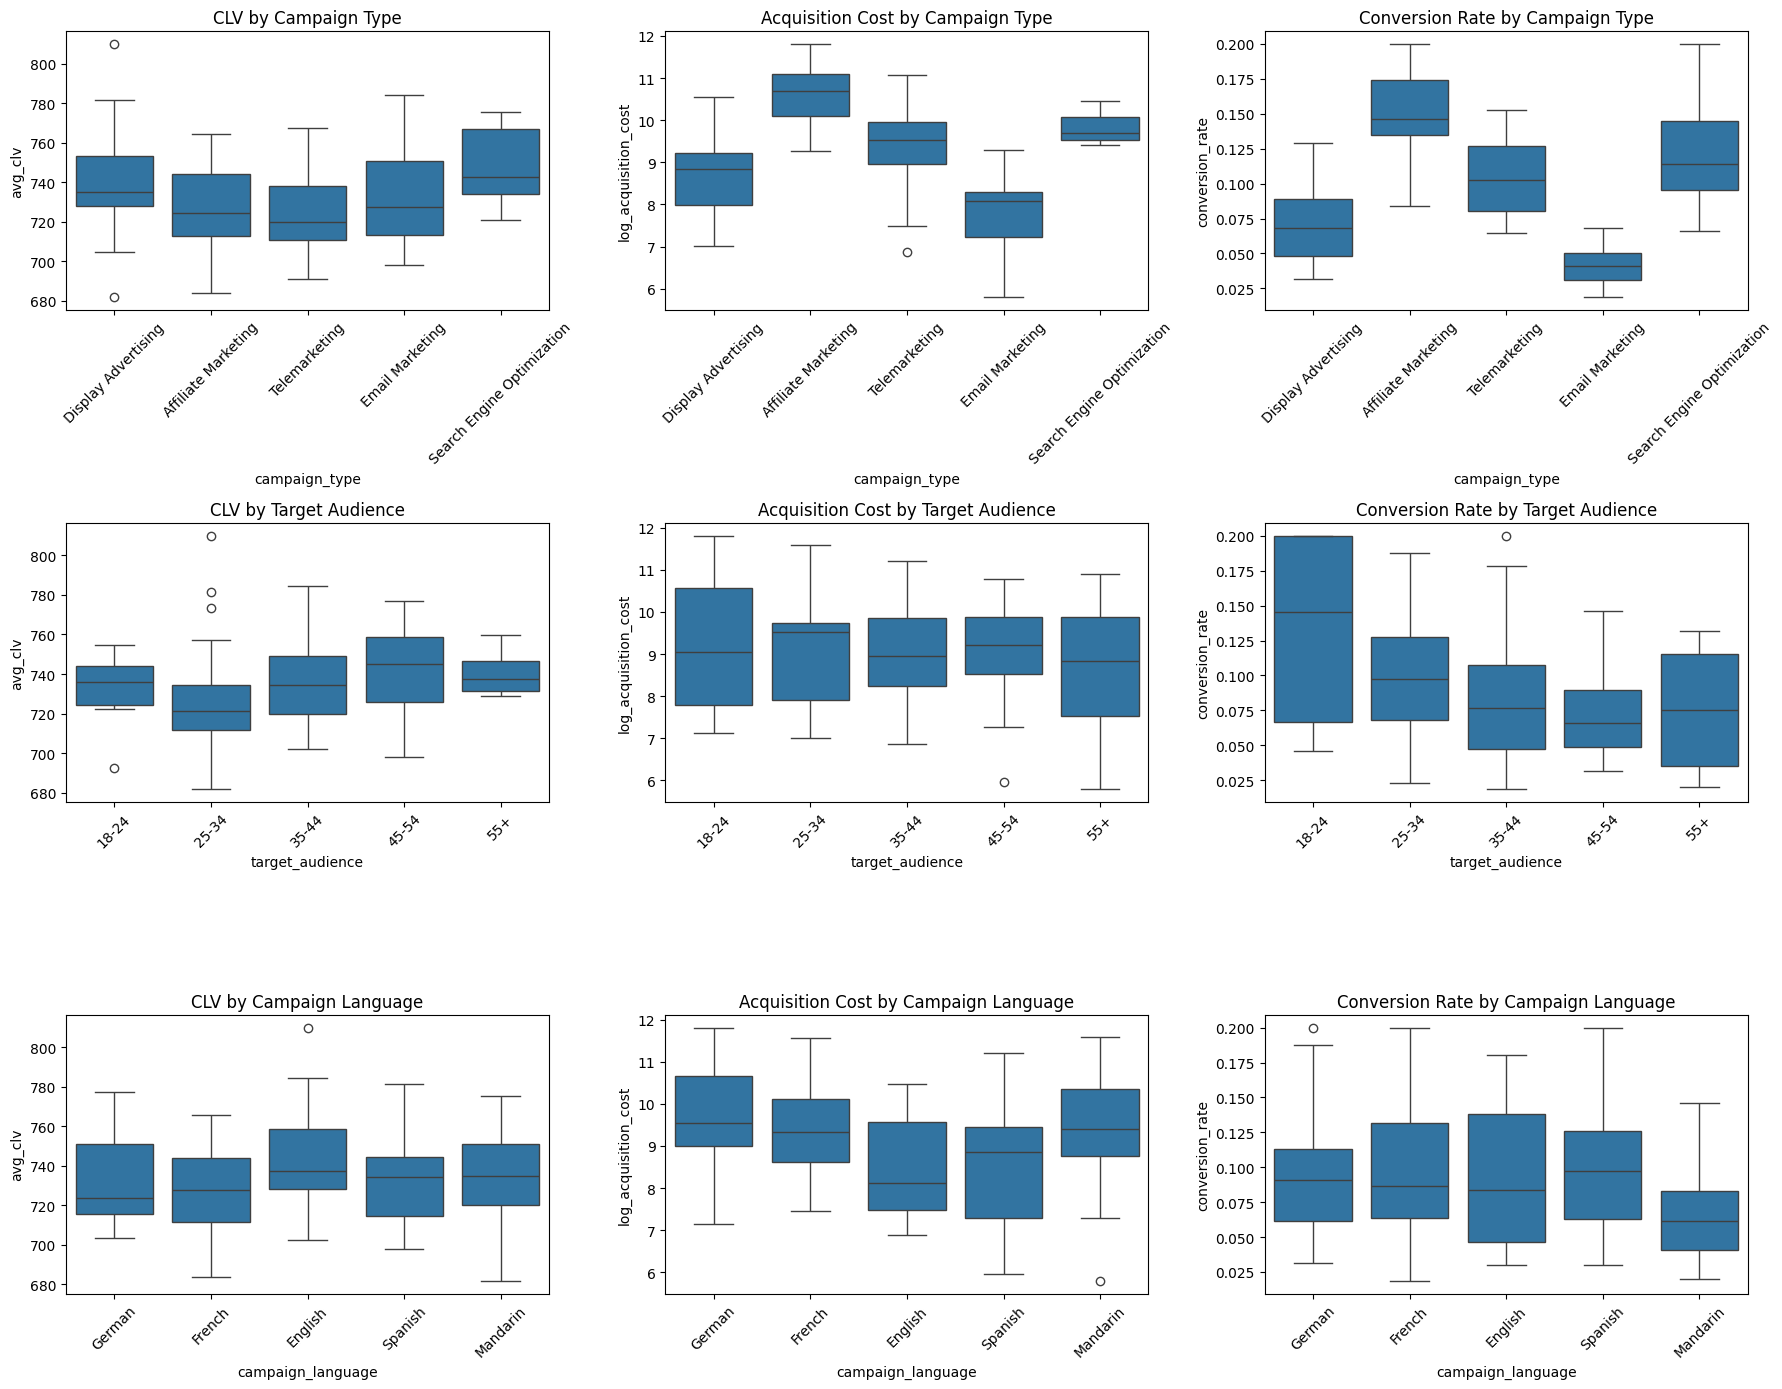

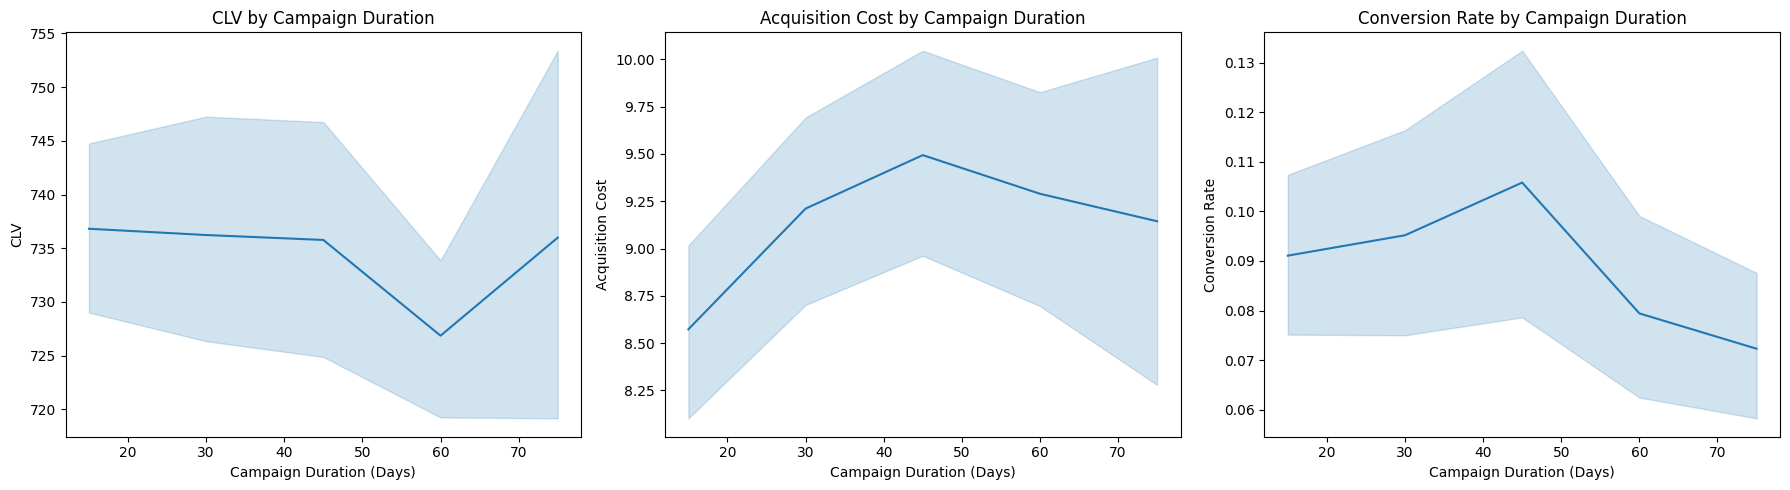

In [481]:
# Configure grid for categorical feature vs CLV, Cost, Conversion Rate
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
categorical_vars = ['campaign_type', 'target_audience', 'campaign_language']
numerical_targets = ['avg_clv', 'log_acquisition_cost', 'conversion_rate']
titles = ['CLV', 'Acquisition Cost', 'Conversion Rate']

# Plot boxplots for categorical features
for i, cat in enumerate(categorical_vars):
    for j, num in enumerate(numerical_targets):
        sns.boxplot(data=df, x=cat, y=num, ax=axes[i, j])
        axes[i, j].set_title(f'{titles[j]} by {cat.replace("_", " ").title()}')
        axes[i, j].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Plot lineplots for campaign_duration vs each numerical target
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for j, num in enumerate(numerical_targets):
    sns.lineplot(data=df, x="campaign_duration", y=num, ax=axes[j])
    axes[j].set_title(f'{titles[j]} by Campaign Duration')
    axes[j].set_xlabel("Campaign Duration (Days)")
    axes[j].set_ylabel(titles[j])

plt.tight_layout()
plt.show()

**Customer Lifetime Value (CLV):**
- Campaign-related features do not significantly differentiate CLV, indicating it is not campaign-specific
- CLV has a relatively small range (680-810)

Hence, we should use the overall mean CLV across all campaigns for building the ROI model

**Acquisition Cost Sub-Model:** \
*Campaign Type:*
- Highest to lowest cost: Affiliate Marketing > Telemarketing > SEO > Display Advertising > Email Marketing
- Strong differentiating factor

*Target Audience:*
- Median acquisition cost is relatively consistent across target audience groups
- Dropped due to low differentiating power

*Campaign Language:*
- Cost decreases from Mandarin → German → French → Spanish → English
- May be attributed to the larger populations of English and Spanish speakers, which makes it more cost-effective to produce campaigns in these languages
- In contrast, languages like Mandarin and German have more limited speaker bases outside their native regions, increasing the cost of campaign production and outreach

*Campaign Duration*
- Slight positive trend between campaign duration and acquisition cost, which could arise from the need for more resources

For the acquisition cost model, we will implement a Linear Regression model on the features `campaign_type`, `campaign_language` and `campaign_duration`. The Linear Regression model was chosen due to its high interpretability, simplicity, and its optimal performance through trial and error with other models.


**Conversion Rate Sub-Model:** \
*Campaign Type:*
- Highest to lowest conversion: Affiliate Marketing > SEO > Telemarketing > Display Advertising > Email Marketing
- Strong differentiating factor

*Target Audience:*
- Conversion rate generally decreases with increased target audience
- Strong differentiating feature

*Campaign Language:*
- Minimal influence on conversion rate, hence dropped

*Campaign Duration* (later omitted to optimize model performance)
- Longer campaigns generally correlate with lower conversion rates

For the conversion model, we will implement a Linear Regression model on the features `campaign_type`, `target_audience` and `campaign_duration`. A Linear Regression model was also chosen based on similar reasons as stated above.

For both sub-models, it is difficult to get a good estimate of the model performance on the test set due to the small dataset size. We will thus incoprorate N-fold Cross Validation to calculate the average value of each performance metric.

### 4. Acquisition Cost Sub-Model

After testing out a few models, a simple Linear Regression model seemed to perform the best. We evaluated the model performance using metrics such as MSE, PMSE, R^2 and adjusted R^2. Then, we extracted the coefficients to analyse the contribuition of each variable to the model prediction.

In [482]:
# Define features and target
X = df[['campaign_type', 'campaign_duration', 'campaign_language']]
y = df['log_acquisition_cost']

# One-hot encoding
categorical_features = ['campaign_type','campaign_language']
numerical_features = ['campaign_duration']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', 'passthrough', numerical_features)
])

# Define pipeline
linreg_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# 5-fold cross-validation (due to small dataset)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Fit model
linreg_model.fit(X, y)

# Cross-validated predictions (log scale → original scale)
log_preds = cross_val_predict(linreg_model, X, y, cv=kf)
preds = np.expm1(log_preds)
true_vals = np.expm1(y)

# Evaluation metrics on original scale
mse_original = mean_squared_error(true_vals, preds)
rmse_original = np.sqrt(mse_original)
r2_original = r2_score(true_vals, preds)
n = len(true_vals)
p = linreg_model.named_steps['preprocessor'].transform(X).shape[1]
adj_r2_original = 1 - (1 - r2_original) * (n - 1) / (n - p - 1)

# Extract coefficients
feature_names = linreg_model.named_steps['preprocessor'].get_feature_names_out()
log_coefficients = linreg_model.named_steps['regressor'].coef_

# Approximate transformation of log-scale coefficients to original scale, interpreted as percent change
original_scale_impact = (np.exp(log_coefficients) - 1) * 100

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Log Coefficient': log_coefficients,
    'Approx % Change in Cost': original_scale_impact
}).sort_values(by='Approx % Change in Cost', ascending=False)

print("Evaluation Metrics (Original Scale):")
print(f" - MSE       : {mse_original:.2f}")
print(f" - RMSE      : {rmse_original:.2f}")
print(f" - R²        : {r2_original:.3f}")
print(f" - Adjusted R² : {adj_r2_original:.3f}")
print("Coefficient Interpretation (Original Scale):")
print(coef_df)

Evaluation Metrics (Original Scale):
 - MSE       : 279064300.49
 - RMSE      : 16705.22
 - R²        : 0.527
 - Adjusted R² : 0.479
Coefficient Interpretation (Original Scale):
                                         Feature  Log Coefficient  \
5                  cat__campaign_language_German         0.727866   
6                cat__campaign_language_Mandarin         0.663568   
4                  cat__campaign_language_French         0.502869   
7                 cat__campaign_language_Spanish         0.049705   
8                         num__campaign_duration         0.011069   
2  cat__campaign_type_Search Engine Optimization        -0.574302   
3               cat__campaign_type_Telemarketing        -1.227986   
0         cat__campaign_type_Display Advertising        -1.906254   
1             cat__campaign_type_Email Marketing        -2.686993   

   Approx % Change in Cost  
5               107.065726  
6                94.170777  
4                65.345887  
7              

**Model Performance** \
The model has an R^2 value of 0.52, suggesting that the model explains about 50% of the variance in the data. Given that acquisition cost not only lies on price predictions but also the success of the campaign, the model performs decently and still provides valuable insights.

The model also produces predictions that deviate about $16700 (RMSE) away from their actual values. While this may seem unideal, it is still a reasonable margin, given that `acquisition_cost` has high variance (std dev = $24000). 

There are some ways to make the model more stable (reduce variance), such as removing outliers, but it often comes at a cost of lower predictive accuracy. Since this model is primarily used to drive business decision-making, we aim for the model to accurately capture relationships between features, even if it is slightly more sensitive to outliers.

**Relationships between Features** \
`campaign_type` and `campaign_language` are key factors that affect the cost of a marketing campaign. Banks who are looking to analyse their marketing expenditure should consider alternative camapign types or languages, while camapign duration should be a secondary consideration.

Campaigns in `German` and `Mandarin` are significantly more expensive, costing almost twice as much as `English` campaigns. This could stem from the need for specialised localization and media targeting in regions where the Portugese bank has limited presence, and limited in-house language resources. In contrast, `Spanish` campaigns are costlier by only 5%. This may be due to a higher volume of English and Spanish speakers in Portugal, as aforementioned. Hence, the Portugese bank should prioritize `English` and `Spanish` campaigns to optimize ROI, and limit high-cost language campaigns like `German` or `Mandarin` unless justified by strong conversion potential.

`Email Marketing` and `Display Advertisting` incurs the lowest cost when compared to `Affiliate Marketing`, reducing cost by 94% and 86% respectively. Hence, for banks that are aiming to cut costs, they could focus more on email marketing campaigns and display advertising, as these channels are easily scalable to a larger audience base without incurring significant additional costs. 

`campaign_duration` only slightly impacts `acquisition_cost`, with longer campaigns associated with an approximate 1% increase. This is likely due to the need for more resources such as manpower, ad space, and continuous tracking of campaign value. However, it is a less significant factor than campaign type, and should not be prioritised as a lever for cost control.

Despite our insights gained on reducing marketing expenditure, we still need to synthesize these insights with the analysis on the value generated from different camapigns to gain a more holistic view of how different campaign types impact ROI.

### 5. Conversion Rate Sub-Model

Similarly, a simple Linear Regression model had the highest performance after experimenting with various models. Dropping the campaign duration feature also seemed to improve the model performance. We perform the same evaluation and analysis as above.

In [483]:
# Define input features and target for conversion rate prediction
X_conv = df[['campaign_type', 'target_audience']]
y_conv = df['conversion_rate']

# One-hot encoding
categorical_features = ['campaign_type', 'target_audience']
preprocessor_conv = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])

# linear regression model pipeline
linreg_model_conv = Pipeline(steps=[
    ('preprocessor', preprocessor_conv),
    ('regressor', LinearRegression())
])

# Cross-validation setup
kf_conv = KFold(n_splits=5, shuffle=True, random_state=42)

# Fit and predict using cross_val_predict
linreg_model_conv.fit(X_conv, y_conv)
preds_conv = cross_val_predict(linreg_model_conv, X_conv, y_conv, cv=kf_conv)

# Evaluate performance
mse_conv = mean_squared_error(y_conv, preds_conv)
rmse_conv = np.sqrt(mse_conv)
r2_conv = r2_score(y_conv, preds_conv)
n_conv = len(y_conv)
p_conv = linreg_model_conv.named_steps['preprocessor'].transform(X_conv).shape[1]
adj_r2_conv = 1 - (1 - r2_conv) * (n_conv - 1) / (n_conv - p_conv - 1)

# Extract coefficients
feature_names_conv = linreg_model_conv.named_steps['preprocessor'].get_feature_names_out()
coefficients_conv = linreg_model_conv.named_steps['regressor'].coef_
coef_df_conv = pd.DataFrame({
    'Feature': feature_names_conv,
    'Coefficient': coefficients_conv
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Return results
{
    "Evaluation Metrics": {
        "MSE": mse_conv,
        "RMSE": rmse_conv,
        "R2": r2_conv,
        "Adjusted R2": adj_r2_conv
    },
    "Coefficients": coef_df_conv
}

{'Evaluation Metrics': {'MSE': 0.0007430448058829415,
  'RMSE': 0.027258848212698597,
  'R2': 0.6558964006569075,
  'Adjusted R2': 0.6253094140486326},
 'Coefficients':                                          Feature  Coefficient
 1             cat__campaign_type_Email Marketing    -0.104614
 0         cat__campaign_type_Display Advertising    -0.079278
 3               cat__campaign_type_Telemarketing    -0.045238
 6                     cat__target_audience_45-54    -0.040431
 7                       cat__target_audience_55+    -0.036546
 2  cat__campaign_type_Search Engine Optimization    -0.025145
 5                     cat__target_audience_35-44    -0.020482
 4                     cat__target_audience_25-34    -0.009143}

**Model Performance** \
The model has an R^2 value of 0.655, suggesting that the model explains about 66% of the variance in the data. Given the relatively high R^2 value and low RMSE (2.8%), the model generally has a good predictive ability and is robust against outliers.

**Relationships between Features** \
`Affiliate Marketing` yields the highest conversion rates, followed by `SEO`, `Telemarketing`, `Display Advertising`, and `Email Marketing`. This aligns with model coefficients—for example, `Email Marketing` has a lower `conversion_rate` of ~10.5 percentage points, while `SEO` has a lower `conversion_rate` of ~2.5 points relative to `Affiliate Marketing`. This may be because affiliate campaigns—often driven by influencers—offer a more personalized and relatable experience that builds trust. In contrast, email marketing tends to be less targeting and often gets filtered out by spam detection systems. Banks should consider allocating more resources to Affiliate and SEO campaigns while re-evaluating their email marketing strategy. Recommendations include avoiding spam-triggering keywords and crafting more personalized, targeted email content to improve reach and engagement.

Generally, campaigns targeted at older age groups have lower conversion rates. Compared to potential customers aged `18-24`, targeting the `45–54` and `55+` segments results in lower conversion rates, reduced by ~4.0 and ~3.7 percentage points respectively. This may be due to lower digital engagement or a preference for in-person banking among older customers. Banks should consider prioritizing younger segments for digital campaigns, while exploring alternative channels or messaging strategies to better engage older audiences.

Once again, these insights should be synthesized with those from other models to generate more holistic reccommendations.

# CLV sub-model